## Create Victim Model

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split, Dataset, TensorDataset

from torchvision.datasets import MNIST, EMNIST
from torchvision import datasets, transforms
import pytorch_lightning as pl

In [2]:
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [3]:
batch_size = 64
num_workers = 4
learning_rate = 1e-3
rand_split_val = [55000, 5000]
gpus = 1
max_epochs = 8 #optimal is 13

In [4]:
 torch.cuda.current_device()

0

In [5]:
class LightningClassifier(pl.LightningModule):
  def __init__(self):
    """Defines a three layer fully connected neural network"""
    super(LightningClassifier, self).__init__()

    # Input images are (1, 28, 28)
    self.layer_1 = torch.nn.Linear(28 * 28, 128)
    self.layer_2 = torch.nn.Linear(128, 256)
    self.layer_3 = torch.nn.Linear(256, 10)

  def forward(self, x):
    """Establishes the neural network's forward pass
    
    Args: 
        x (Torch tensor): MNIST input image

    Returns:
        x (Torch tensor): output probability vector for MNIST classes
    """
    batch_size, channels, width, height = x.size()

    # Input Layer: (batch_size, 1, 28, 28) -> (batch_size, 1*28*28)
    x = x.view(batch_size, -1)

    # Layer 1: (batch_size, 1*28*28) -> (batch_size, 128)
    x = self.layer_1(x)
    x = torch.relu(x)

    # Layer 2: (batch_size, 128) -> (batch_size, 256)
    x = self.layer_2(x)
    x = torch.relu(x)

    # Layer 3: (batch_size, 256) -> (batch_size, 10)
    x = self.layer_3(x)

    x = torch.log_softmax(x, dim=1)
    return x

  def cross_entropy_loss(self, logits, labels):
    """Calculates loss- the difference between model predictions and true labels
    
    Args:
        logits (Torch tensor): model output predictions
        labels (Torch tensor): true values for predictions
    """
    return F.cross_entropy(logits, labels)

  def training_step(self, train_batch, batch_idx):
    """Pushes training data batch through model and calculates loss in loop

    Args: 
        train_batch (Torch tensor): batch of training data from training dataloader 
        batch_idx (int): index of batch in contention

    Returns: 
        Formatted string with cross entropy loss and training logs
    """
    x, y = train_batch
    logits = self.forward(x)
    loss = self.cross_entropy_loss(logits, y)
    logs = {'train_loss': loss}
    return {'loss': loss, 'log': logs}

  def validation_step(self, val_batch, batch_idx):
    """Pushes validation data batch through model and calculates loss in loop

    Args: 
        val_batch (Tensor): batch of validation data from validation dataloader 
        batch_idx (int): index of batch in contention

    Returns: 
        Formatted string with resultant cross entropy loss 
    """
    x, y = val_batch
    logits = self.forward(x)
    loss = self.cross_entropy_loss(logits, y)
    targets_hat = torch.argmax(logits, dim=1)
    n_correct_pred = torch.sum(y == targets_hat).item()
    return {'val_loss': loss, 'n_correct_pred': n_correct_pred, "n_pred": len(x)}

  def validation_epoch_end(self, outputs):
    """Returns validation step results at the end of the epoch

    Args: 
        outputs (array): result of validation step for each batch 

    Returns: 
        Formatted string with resultant metrics
    """
    avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    tensorboard_logs = {'val_loss': avg_loss}
    return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

  def configure_optimizers(self):
    """Sets up the optimization scheme"""
    optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
    return optimizer
    
  def test_step(self, batch, batch_idx):
    """Pushes test data into the model and returns relevant metrics
    
    Args:
        batch (Torch tensor): batch of test data from test dataloader 
        batch_idx (int): index of batch in contention

    Returns:
        Formatted string with relevant metrics
    """
    x, y = batch
    y_hat = self(x)
    targets_hat = torch.argmax(y_hat, dim=1)
    n_correct_pred = torch.sum(y == targets_hat).item()
    return {'test_loss': F.cross_entropy(y_hat, y), "n_correct_pred": n_correct_pred, "n_pred": len(x)}

  def test_epoch_end(self, outputs):
    """Returns test step results at the end of the epoch

    Args: 
        outputs (array): result of test step for each batch 

    Returns: 
        Formatted string with resultant metrics
    """
    avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
    #avg_n_correct_pred = torch.stack([x['n_correct_pred'] for x in outputs]).mean()
    #avg_n_pred = torch.stack([x['n_pred'] for x in outputs]).mean()
    tensorboard_logs = {'test_loss': avg_loss}
    return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}
            #"ang_n_correct_pred": avg_n_correct_pred, "avg_n_pred": avg_n_pred, 'log': tensorboard_logs}


In [6]:
transform=transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
mnist_train, mnist_val = random_split(mnist_train, rand_split_val)

train_dataloader = DataLoader(mnist_train, batch_size=batch_size, num_workers=num_workers)
val_dataloader = DataLoader(mnist_val, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(mnist_test, batch_size=batch_size, num_workers=num_workers)


In [7]:
def train_and_test(classifier, gpus, num_nodes, max_epochs, train_dataloader, val_dataloader, test_dataloader):
    model = classifier()
    trainer = pl.Trainer(gpus=gpus, num_nodes=num_nodes, max_epochs=max_epochs)
    trainer.fit(model, train_dataloader, val_dataloader)
    trainer.test(model, test_dataloaders=test_dataloader)
    return model

In [8]:
mnist_model = train_and_test(LightningClassifier, gpus, 1, max_epochs, train_dataloader, val_dataloader, test_dataloader)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33 K  
2 | layer_3 | Linear | 2 K   


/home/suhacker/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_loss': tensor(0.1136, device='cuda:0'),
 'test_loss': tensor(0.1136, device='cuda:0')}
--------------------------------------------------------------------------------



In [9]:
def convert_to_inference(model):
    """Allows a model to be used in an inference setting"""
    model.freeze()
    model.eval()
    model.cuda()
    return model

In [10]:
mnist_model = convert_to_inference(mnist_model)

In [11]:
def show_test_image(model, dataset, idx):
    """Shows a single image from the test dataset"""
    x, y = dataset[idx]
    plt.imshow(x.numpy()[0], cmap='gray')
    return x

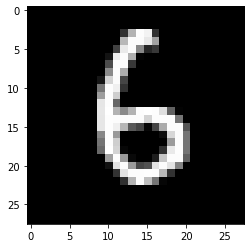

In [12]:
sample_image = show_test_image(mnist_model, mnist_test, 21)

In [14]:
def query_model(model, image):
    """Returns the predictions of a model given an image
    
    Args: 
        model(pl.LightningModule): model to be queried 
        image (Numpy Array): input MNIST image 

    Returns: 
        prediction (Torch tensor): output with class probabilities 
        np_prediction (Numpy Array): output with class probabilities 
        label (int): model's top choice for class shown in image
    """
    image = image.cuda()
    image = image.resize_(1, 28, 28, 1)
    prediction = model(image)
    np_prediction = prediction.cpu().numpy()
    target = np.argmax(np_prediction)
    #print("The image is of the number", label, "\n")
    return prediction, np_prediction, target

def get_query_target(model, image):
    prediction, np_prediction, target = query_model(model, image)
    return target

In [15]:
pred_x, np_pred_x, label_x = query_model(mnist_model, sample_image)

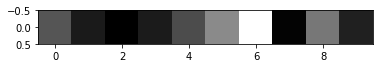

In [16]:
#Show plot of class probabilities; the lightest box is the most likely label
plt.imshow(np_pred_x, cmap='gray')

## Retraining with uniform queries

In [0]:
k = 30000

synthetic_images = torch.empty(1, 28, 28).uniform_(-2, 3)
pred_x, np_pred_x, synthetic_targets = query_model(mnist_model, synthetic_images)
synthetic_targets = torch.tensor([synthetic_targets])

for i in range(k-1):
    s = torch.empty(1, 28, 28).uniform_(0, 1)
    pred_x, np_pred_x, s_target = query_model(mnist_model, s)
    synthetic_images = torch.cat((synthetic_images, s))
    s_target = torch.tensor([s_target])
    synthetic_targets = torch.cat((synthetic_targets, s_target))

synthetic_images = torch.reshape(synthetic_images, (k, 1, 28, 28))
#y = torch.eye(10) 
#synthetic_targets = y[synthetic_targets]
#synthetic = (synthetic_image, synthetic_target)

#do manual split into test, train, valid -> dataset -> dataloaders

train_image, test_image, train_targets, test_targets = train_test_split(synthetic_images, synthetic_targets, test_size=0.3, random_state=42)
test_image, valid_image, test_targets, valid_targets = train_test_split(test_image, test_targets, test_size=0.5, random_state=42)


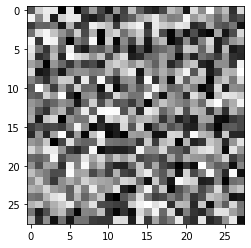

In [0]:
plt.imshow(synthetic_images[0].numpy()[0], cmap='gray')
#synthetic_images[0]

In [0]:
# Define dataset class and loaders

class CustomDataset(Dataset):
    
    def __init__(self, images, targets, transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # ToTensor() -  define the numpy array like (H, W, C)
        #image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28, 28, 1))
        #label = self.data.iloc[index, 0]
        image = self.images[index]
        target = self.targets[index]
        
        if self.transform is not None:
            #image = image.numpy()
            image = self.transform(image.numpy())
            #image = torch.from_numpy(image)

            
        return image, target

In [0]:
synthetic_train = CustomDataset(train_image, train_targets, transform=transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))]))

synthetic_valid = CustomDataset(valid_image, valid_targets, transform=transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))]))

synthetic_test = CustomDataset(test_image, test_targets, transform=transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))]))

synthetic_train_dataloader = DataLoader(synthetic_train, batch_size=batch_size, num_workers=num_workers)
synthetic_val_dataloader = DataLoader(synthetic_valid, batch_size=batch_size, num_workers=num_workers)
synthetic_test_dataloader = DataLoader(synthetic_test, batch_size=batch_size, num_workers=num_workers)

In [0]:
synthetic_model = train_and_test(LightningClassifier, gpus, 1, max_epochs, synthetic_train_dataloader, synthetic_val_dataloader, synthetic_test_dataloader)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33 K  
2 | layer_3 | Linear | 2 K   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_loss': tensor(0.0293, device='cuda:0'),
 'test_loss': tensor(0.0293, device='cuda:0')}
--------------------------------------------------------------------------------



In [0]:
synthetic_model = convert_to_inference(synthetic_model)

3

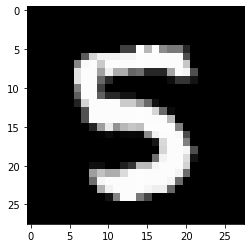

In [0]:
sample_image = show_test_image(synthetic_model, mnist_test, 120)
pred_x, np_pred_x, label_x = query_model(synthetic_model, sample_image)
label_x

In [0]:
label_x

3